# Necessary Imports

In [1]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import seaborn as sns
import pathlib
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# Data Loading & Train Test Split

In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/axialdb/Axial",
    validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=[180, 180],
    batch_size=16,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/axialdb/Axial",
    validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=[180, 180],
    batch_size=16 ,
)

Found 5154 files belonging to 3 classes.
Using 3608 files for training.
Found 5154 files belonging to 3 classes.
Using 1546 files for validation.


In [3]:
Num_Images = []
classnames = train_ds.class_names
len(classnames),train_ds.class_names
for label in classnames:
    dir_name = "/kaggle/input/axialdb/Axial" +'/'+ label 
    Num_Images.append(len([name for name in os.listdir(dir_name)]))
    
Num_Images,classnames

([1124, 2590, 1440], ['AD', 'CI', 'CN'])

In [4]:
IMG_DIM = 180
IMAGE_SHAPE = [180, 180]
INPUT_SIZE = (IMG_DIM, IMG_DIM)
ZOOM_RANGE = [.99, 1.01]
BRIGHTNESS_ADJUST = [0.8, 1.2]
HORIZONTAL_FLIP = True
PIXEL_FILL_MODE = "constant"
CHANNEL_ORDER = "channels_last"
DATASET_PATH = "/kaggle/input/axialdb/Axial"

data_generator = IDG(
    rescale=1./255, 
    brightness_range=BRIGHTNESS_ADJUST, 
    zoom_range=ZOOM_RANGE, 
    data_format=CHANNEL_ORDER, 
    fill_mode=PIXEL_FILL_MODE, 
    horizontal_flip=HORIZONTAL_FLIP
)

training_data_loader = data_generator.flow_from_directory(
    directory=DATASET_PATH, 
    target_size=INPUT_SIZE, 
    batch_size=8000, 
    shuffle=False
)

Found 5154 images belonging to 3 classes.


In [5]:
train_data, train_labels = next(training_data_loader)

In [6]:
print(train_data.shape, train_labels.shape)

(5154, 180, 180, 3) (5154, 3)


In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.3, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.3, random_state=42)

# Define The Model Architecture 

In [11]:
from tensorflow.keras.applications import VGG19
# Load Pretrained VGG19 Model
vgg19 = VGG19(input_shape=(180, 180, 3), weights='imagenet', include_top=False)

# Freeze all layers in VGG19
for layer in vgg19.layers:
    layer.trainable = False

# Add custom classification layers
x_vgg19 = Flatten()(vgg19.output)  # Use vgg19.output instead of resnet.output
prediction_vgg19 = Dense(3, activation='softmax')(x_vgg19)

# Create VGG19 model
model_vgg19 = Model(inputs=vgg19.input, outputs=prediction_vgg19)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [12]:
model_vgg19.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,062,787 (76.53 MB)

 Trainable params: 38,403 (150.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

# Callbacks for Training

In [13]:
# Compile the VGG19 model
model_vgg19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Define Callbacks
checkpoint_vgg19 = ModelCheckpoint(filepath='vgg19_model.weights.h5', save_best_only=True, save_weights_only=True)
lr_vgg19 = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='min')  # Changed mode to 'min'
early_stop_vgg19 = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')


# Training The Model

In [20]:
# Train the model with callbacks
history_vgg19 = model_vgg19.fit(
    train_data,train_labels, 
    epochs=20,validation_data = (val_data,val_labels),
    callbacks=[checkpoint_vgg19, lr_vgg19]
)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 227ms/step - accuracy: 0.9324 - loss: 0.2502 - val_accuracy: 0.8717 - val_loss: 0.3597 - learning_rate: 0.0010
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 197ms/step - accuracy: 0.9657 - loss: 0.1964 - val_accuracy: 0.8633 - val_loss: 0.3620 - learning_rate: 0.0010
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9663 - loss: 0.2019
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - accuracy: 0.9663 - loss: 0.2019 - val_accuracy: 0.8504 - val_loss: 0.4181 - learning_rate: 0.0010
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.9665 - loss: 0.1952 - val_accuracy: 0.8957 - val_loss: 0.3297 - learning_rate: 3.0000e-04
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - accuracy: 0.9731 - loss: 0.1735 - val_accuracy: 0.8994 - val_loss: 0.3286 - learning_rate: 3.0000e-04
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - accuracy: 0.9735 - lo

# Testing

In [21]:
test_scores = model_vgg19.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.8807 - loss: 0.3234
Testing Accuracy: 87.65%


In [22]:
pred_labels1 = model_vgg19.predict(test_data)

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step


# Confusion Matrix & Classification Report

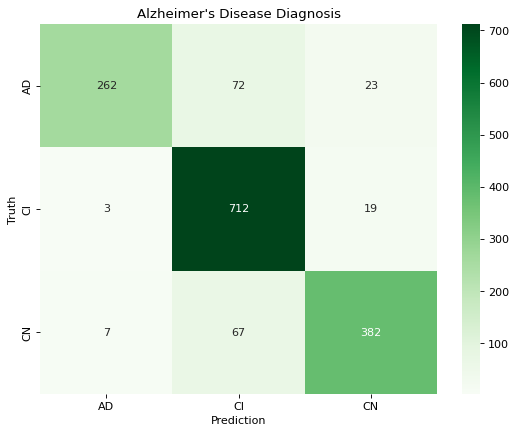

In [23]:
pred_ls = np.argmax(pred_labels1, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= classnames,
                yticklabels=classnames)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [24]:
print(classification_report(test_ls, pred_ls, target_names=classnames))

              precision    recall  f1-score   support

          AD       0.96      0.73      0.83       357
          CI       0.84      0.97      0.90       734
          CN       0.90      0.84      0.87       456

    accuracy                           0.88      1547
   macro avg       0.90      0.85      0.87      1547
weighted avg       0.88      0.88      0.87      1547

